# Machine Learning Analysis - London Housing Data

This notebook will apply supervised ML models from scikit-learn to analyse the real estate data in ```10m_london_houses_.csv```.

## Plan
Split into 3 sections by the data used: SQM-only, all data and top features
- SQM-only: get data, run simple models, plot predictions and show R2 for some cross-validation folds (no HP tuning)
- All data: go into more detail and do HP tuning
    - Prepare data: convert categoric to dummy variables, scale data
    - HP tune the models via RandomizedSearchCV
    - Evaluate the models using R2, RMSE (NMSE?), MAE and MAPE
    - Plot results for the best model's ```best_estimator_```
- Top features: compare the performance of models using just the top features with the last models
    - Run PCA - determine the top third of features
    - Train models on just these features
    - HP tune these models via RandomizedSearchCV
    - Evaluate the models using R2, RMSE (NMSE?), MAE and MAPE
- Conlusion
    - How good are the models?
    - What have we learned?
    - Any key takeaways

Repository link: [Github](https://github.com/rsamconn/London-housing)

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, Ridge

print(np.NaN)

nan


In [2]:
# Load the data
housing_df = pd.read_csv('data/10m_london_houses_.csv')

# Reminder of how the data looks
print(f"Dataset shape: {housing_df.shape}")
display(housing_df.head())

Dataset shape: (1000, 17)


,Address,Neighborhood,Bedrooms,Bathrooms,Square Meters,Building Age,Garden,Garage,Floors,Property Type,Heating Type,Balcony,Interior Style,View,Materials,Building Status,Price (£)
0,78 Regent Street,Notting Hill,2,3,179,72,No,No,3,Semi-Detached,Electric Heating,High-level Balcony,Industrial,Garden,Marble,Renovated,2291200
1,198 Oxford Street,Westminster,2,1,123,34,Yes,No,1,Apartment,Central Heating,High-level Balcony,Industrial,City,Laminate Flooring,Old,1476000
2,18 Regent Street,Soho,5,3,168,38,No,Yes,3,Semi-Detached,Central Heating,No Balcony,Industrial,Street,Wood,Renovated,1881600
3,39 Piccadilly Circus,Islington,5,1,237,53,Yes,Yes,1,Apartment,Underfloor Heating,No Balcony,Classic,Park,Granite,Renovated,1896000
4,116 Fleet Street,Marylebone,4,1,127,23,No,Yes,2,Semi-Detached,Central Heating,No Balcony,Modern,Park,Wood,Old,1524000


Our data has 1000 rows and 17 columns: 6 columns of numeric data and 11 with categoric data. You can find a thorough analysis of them in the EDA notebook.

First, let's set aside 100 randomly selected rows to be used for evaluating the model outputs later.

In [138]:
evaluation_set = housing_df.sample(frac=0.1, random_state=24)
train_test_df = housing_df.drop(evaluation_set.index).reset_index(drop=True)
evaluation_df = evaluation_set.reset_index(drop=True)

## Attempt 1 - only look at house area
It's often mentioned that the most important factor in determining house prices is the size.

Let's take a look at that idea by building a model that only uses the Square Meters data as a feature.

First, we get our feature and target data and split it into test and training set.

In [139]:
# Create Square Meters only dataset from the training/testing data
X_sqm = train_test_df['Square Meters'].values.reshape(-1, 1) # Feature matrix
y = train_test_df['Price (£)'].values # Target vector
X_train_sqm, X_test_sqm, y_train_sqm, y_test_sqm = train_test_split(X_sqm, y, test_size=0.3, random_state=24)

print(X_train_sqm.shape, X_test_sqm.shape, y_train_sqm.shape, y_test_sqm.shape)

(630, 1) (270, 1) (630,) (270,)


Next, we instantiate and fit our models

In [140]:
# Instantiate models
linreg_sqm = LinearRegression()
lasso_sqm = Lasso(alpha = 0.1)
ridge_sqm = Ridge(alpha = 0.1)

# Fit to numeric data
linreg_sqm.fit(X_train_sqm, y_train_sqm)
lasso_sqm.fit(X_train_sqm, y_train_sqm)
ridge_sqm.fit(X_train_sqm, y_train_sqm)

# Save models to a dictionary
models_sqm = {
    'Linear (SQM)': linreg_sqm,
    'Lasso (SQM)': lasso_sqm,
    'Ridge (SQM)': ridge_sqm
}

Now we can visualise their predictions and do some simple testing.

Since we'll want to this visualization again later, let's create a function for it.

In [141]:
def score_predict_plot(model_dict, X_train, y_train, X_test, y_test, X_test1D, title='Model predictions'):
    """Evaluate multiple models and plot their predictions vs actual values."""
    
    # Create figure and plot the actual results
    plt.figure(figsize=(10, 6))
    plt.scatter(X_test1D, y_test, label='Actual', color='black', alpha=0.9, s=20)
    
    # Loop over models
    for model_name, model in model_dict.items():
        # Predict and plot
        y_pred = model.predict(X_test)
        plt.scatter(X_test1D, y_pred, label=model_name, alpha=0.5, s=20)
        # Calculate and print R² scores
        train_score = model.score(X_train, y_train)
        test_score = model.score(X_test, y_test)
        print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")
        
    plt.xlabel('Square meters [m^2]', fontsize=11)
    plt.ylabel('Price [£]', fontsize=11)
    plt.title(title, fontsize=12, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


Linear (SQM) training--testing R²: 0.6297--0.6253
Lasso (SQM) training--testing R²: 0.6297--0.6253
Ridge (SQM) training--testing R²: 0.6297--0.6253


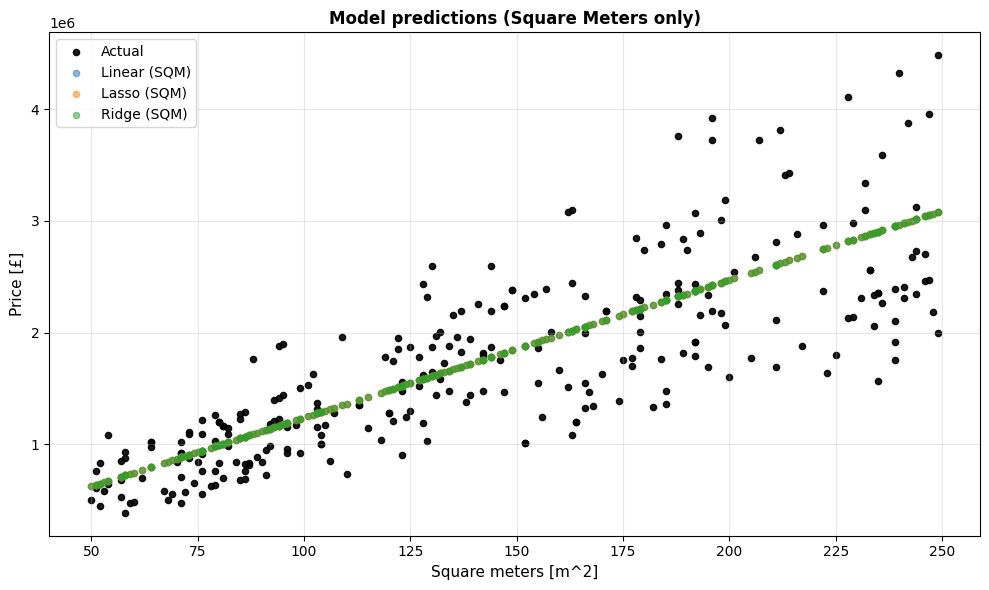

In [143]:
score_predict_plot(models_sqm,
                   X_train_sqm, y_train_sqm, X_test_sqm, y_test_sqm, X_test_sqm,
                   title='Model predictions (Square Meters only)')

We can see the models have drawn a straight line through the data, as linear regression models are designed to do.

The models' $R^2$ scores of around 0.6 means they explain 60% of the variance in the data.

Let's go slightly deeper on the performance with some cross validation.

In [164]:
from sklearn.model_selection import KFold, cross_val_score
kf20 = KFold(n_splits=10, shuffle=True, random_state=23)

print('cross-validation scores: min--mean--max (std.)')
def cross_val_models(models_dict, X, y, cv):
    for model_name, model in models_dict.items():
        cv_scores = cross_val_score(model, X, y, cv=cv, scoring='r2')
        print(f'{model_name}: {np.min(cv_scores):.3f} --- {np.mean(cv_scores):.3f} --- {np.max(cv_scores):.3f} ({cv_scores.std():.3f})')
    return

print('Cross-validation on training set:')
cross_val_models(models_sqm, X_train_sqm, y_train_sqm, kf20)
print('Cross-validation on test set:')
cross_val_models(models_sqm, X_test_sqm, y_test_sqm, kf20)

cross-validation scores: min--mean--max (std.)
Cross-validation on training set:
Linear (SQM): 0.494 --- 0.622 --- 0.758 (0.071)
Lasso (SQM): 0.494 --- 0.622 --- 0.758 (0.071)
Ridge (SQM): 0.494 --- 0.622 --- 0.758 (0.071)
Cross-validation on test set:
Linear (SQM): 0.408 --- 0.597 --- 0.727 (0.089)
Lasso (SQM): 0.408 --- 0.597 --- 0.727 (0.089)
Ridge (SQM): 0.408 --- 0.597 --- 0.727 (0.089)


After checking the model scores across 20 different cross validation folds, we see the $R^2$ can go pretty low, but in general it's around 0.5-0.7 - not great, but not bad for a single feature.

Interestingly, the models all produce idental results and scores.

Let's make some models that take advantage of all of the data.

## Attempt 2 - use all data
Let's now see how well the models can do with all the data available.

### 2.1 Data preparation
First, we need to prepare the data in a few ways:
- Drop the 'Address' column, since most values are unique and this would blow up our feature set.
- Encode categorical data using Pandas' ```get_dummies()``` function.
- Convert the resulting data into numerical format.

In [150]:
# Check how many unique values are in the addresses column of the housing_train_test_df
print(f'Unique addresses: {housing_train_test_df["Address"].nunique()}')

# Drop the Address column, apply get_dummies to the remaining categorical columns
housing_train_test_df_encoded = pd.get_dummies(
    housing_train_test_df.drop(columns=['Address']), drop_first=True
).astype(np.float32)

all_cols = housing_train_test_df_encoded.columns.tolist()
print(f'All columns ({len(all_cols)}): {all_cols}')
housing_train_test_df_encoded.shape

Unique addresses: 710
All columns (36): ['Bedrooms', 'Bathrooms', 'Square Meters', 'Building Age', 'Floors', 'Price (£)', 'Neighborhood_Chelsea', 'Neighborhood_Greenwich', 'Neighborhood_Islington', 'Neighborhood_Kensington', 'Neighborhood_Marylebone', 'Neighborhood_Notting Hill', 'Neighborhood_Shoreditch', 'Neighborhood_Soho', 'Neighborhood_Westminster', 'Garden_Yes', 'Garage_Yes', 'Property Type_Detached House', 'Property Type_Semi-Detached', 'Heating Type_Electric Heating', 'Heating Type_Gas Heating', 'Heating Type_Underfloor Heating', 'Balcony_Low-level Balcony', 'Balcony_No Balcony', 'Interior Style_Industrial', 'Interior Style_Minimalist', 'Interior Style_Modern', 'View_Garden', 'View_Park', 'View_Sea', 'View_Street', 'Materials_Laminate Flooring', 'Materials_Marble', 'Materials_Wood', 'Building Status_Old', 'Building Status_Renovated']


(900, 36)

Now we split into testing and training data again, then scale the results.

In [166]:
X_all = housing_train_test_df_encoded.drop(columns=['Price (£)']).values
y_all = housing_train_test_df_encoded['Price (£)'].values

X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(X_all, y_all, test_size=0.3, random_state=24)
# Save the Square Meters column from X_test_all for plotting later
X_test_sqm_from_all = X_test_all[:, 2].reshape(-1, 1)

print(X_train_all.shape, X_test_all.shape, y_train_all.shape, y_test_all.shape)

(630, 35) (270, 35) (630,) (270,)


In [165]:
housing_train_test_df_encoded.columns.get_loc('Square Meters')

2

In [167]:
# Import StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_all = scaler.fit_transform(X_train_all)
X_test_all = scaler.transform(X_test_all)

Let's take a quick peek at the models' training $R^2$ scores now that we've included all features:

In [156]:
# Instantiate models for all features
models_all = {
    'Linear (All)': LinearRegression(),
    'Lasso (All)': Lasso(alpha = 0.1),
    'Ridge (All)': Ridge(alpha = 0.1)
}
   
# Fit each model and print R² scores
for model_name, model in models_all.items():
    model.fit(X_train_all, y_train_all)
    train_score = model.score(X_train_all, y_train_all)
    test_score = model.score(X_test_all, y_test_all)
    print(f"{model_name} training--testing R²: {train_score:.4f}--{test_score:.4f}")

Linear (All) training--testing R²: 0.9494--0.9427
Lasso (All) training--testing R²: 0.9494--0.9427
Ridge (All) training--testing R²: 0.9494--0.9427


Wow - a 50% increase in the $R^2$ values!

Now let's do some hyperparameter tuning for the Lasso and Ridge models.

### 2.2 Tuning

We'll use ```sklearn```'s ```RandomizedSearchCV``` function.

In [160]:
from sklearn.model_selection import RandomizedSearchCV

# Set the hyperparameter grids for Lasso and Ridge
lasso_params = {'lasso__alpha': np.linspace(0.001, 10, 100)}
ridge_params = {'ridge__alpha': np.linspace(0.001, 10, 100)}
params = {'alpha': np.linspace(0.001, 10, 100)}

randomCV_lasso_all = RandomizedSearchCV(models_all['Lasso (All)'], params, cv=kf20, n_iter=20, random_state=24)
randomCV_ridge_all = RandomizedSearchCV(models_all['Ridge (All)'], params, cv=kf20, n_iter=20, random_state=24)

models_all_cvs = {
    'Lasso Regression (All)': randomCV_lasso_all,
    'Ridge Regression (All)': randomCV_ridge_all
}

In [161]:
results_dict = {}
for name, model in models_all_cvs.items():
    model.fit(X_train_all, y_train_all)
    print('{} {} {}'.format(5*'-', name, 5*'-'))
    print(f'Top score: {model.best_score_:.4f}')
    print(f'Top params: {model.best_params_}')
    results_dict[name] = [model.best_score_, model.best_params_]

----- Lasso Regression (All) -----
Top score: 0.9405
Top params: {'alpha': 9.495}
----- Ridge Regression (All) -----
Top score: 0.9407
Top params: {'alpha': 4.849000000000001}


We see the best performing models had alpha values of around **9.5 for Lasso** and **4.85 for Ridge**.

Let's save those best models and see how the predictions look now using our plotting fucntion defined earlier.

Linear Regression (All) training--testing R²: 0.9494--0.9427
Best Lasso (All) training--testing R²: 0.9494--0.9427
Best Ridge (All) training--testing R²: 0.9493--0.9427


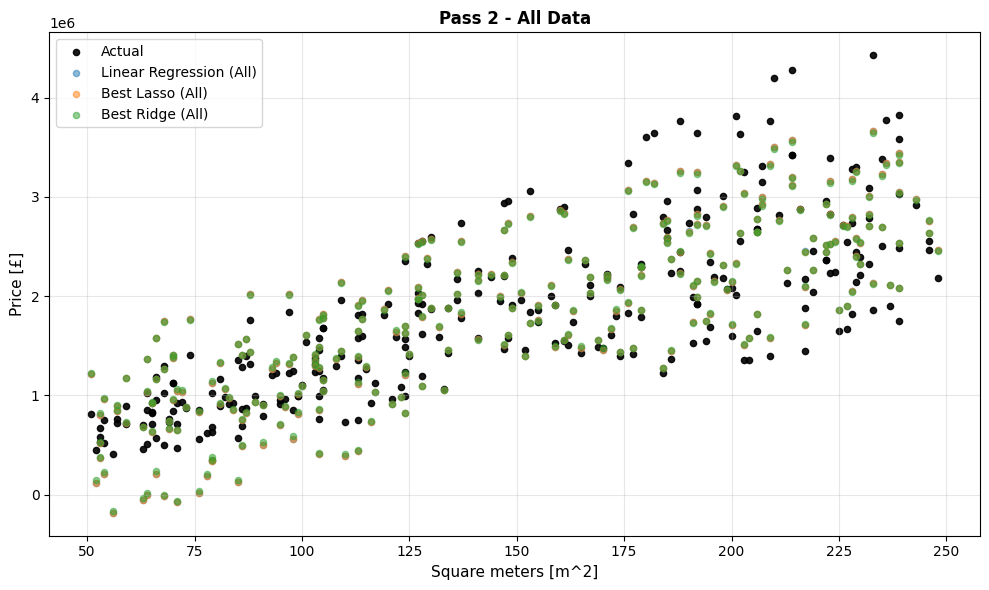

In [169]:
best_models = {
    'Linear Regression (All)': models_all['Linear (All)'],
    'Best Lasso (All)': randomCV_lasso_all.best_estimator_,
    'Best Ridge (All)': randomCV_ridge_all.best_estimator_
}

score_predict_plot(best_models,
                   X_train_all, y_train_all, X_test_all, y_test_all,
                   X_test_sqm_from_all, title='Pass 2 - All Data')

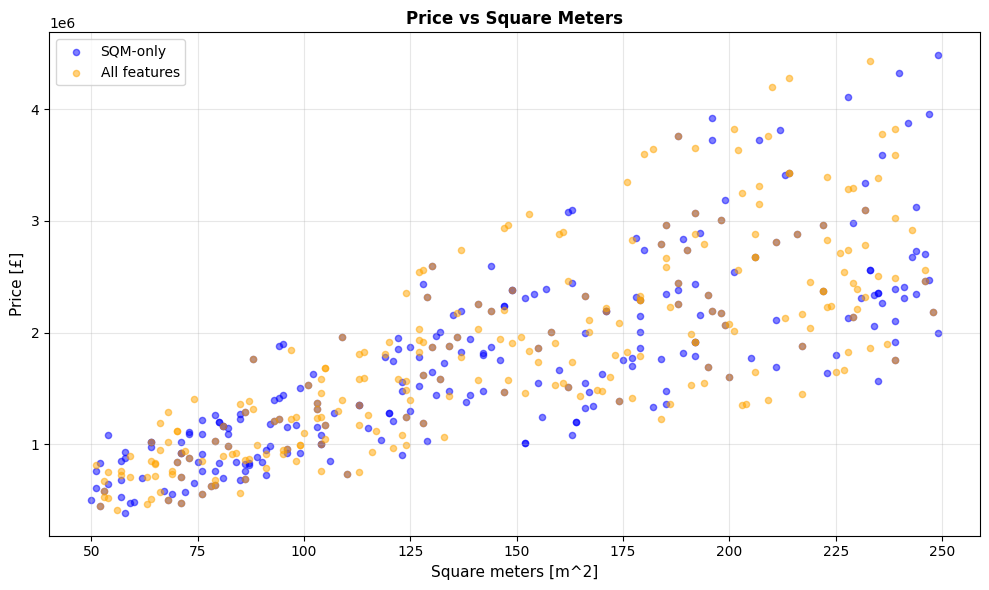

In [168]:
# Plot the Price column vs Square Meters column for both the train_test_df and housing_df.head(900)
plt.figure(figsize=(10, 6))
plt.scatter(X_test_sqm, y_test_sqm, label='SQM-only', color='blue', alpha=0.5, s=20)
plt.scatter(X_test_sqm_from_all, y_test_all, label='All features', color='orange', alpha=0.5, s=20)
plt.xlabel('Square meters [m^2]', fontsize=11)
plt.ylabel('Price [£]', fontsize=11)
plt.title('Price vs Square Meters', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)   
plt.tight_layout()
plt.show()

Now the model predictions look much closer to the actual values.

Now let's do a deeper evaluation of our best models.

### 2.4 Model Evaluation
We've already seen the model has a high $R^2$, which means it does well at explaining the variation in the data. The test and training $R^2$ values are also close, which is good because it implies we've avoided overfitting.

We'll evaluate the model on 3 key parameters:
- The Root Mean Squared Error (RMSE)
- The Mean Aboslute Error (MAE) - this tells us on average how close our models' estimates are in £.
- The Mean Aboslute Percentage Error (MAPE) - this tells us on average how close our models' estimates are in percentage terms.

These will tell us how well our model actually does on predicting house prices.

For this section we will finally use the validation set we saved earlier - first we'll need to clean it slightly.

In [134]:
housing_validation_set_encoded = pd.get_dummies(
    housing_validation_df.drop(columns=['Address']), drop_first=True
).astype(np.float32)

validation_set_features = housing_validation_set_encoded.drop(columns=['Price (£)']).values
validation_set_target = housing_validation_set_encoded['Price (£)'].values

validation_set_features_scaled = scaler.transform(validation_set_features)

validation_set_features_scaled

array([[ 0.7248315 ,  1.2507107 , -1.233252  , ...,  1.69194   ,
         1.4727572 , -0.730219  ],
       [ 0.00480021,  0.01238327,  0.8784744 , ...,  1.69194   ,
         1.4727572 , -0.730219  ],
       [ 0.00480021, -1.2259442 , -0.58084875, ...,  1.69194   ,
         1.4727572 , -0.730219  ],
       ...,
       [ 0.7248315 , -1.2259442 ,  0.72395784, ..., -0.5910375 ,
         1.4727572 , -0.730219  ],
       [ 1.4448628 ,  0.01238327, -0.30615264, ..., -0.5910375 ,
        -0.6789985 ,  1.3694522 ],
       [ 0.7248315 ,  0.01238327,  0.62094676, ...,  1.69194   ,
         1.4727572 , -0.730219  ]], dtype=float32)

In [127]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [135]:
best_models['Best Ridge (All)'].score(validation_set_features_scaled, validation_set_target)

-8.095420837402344

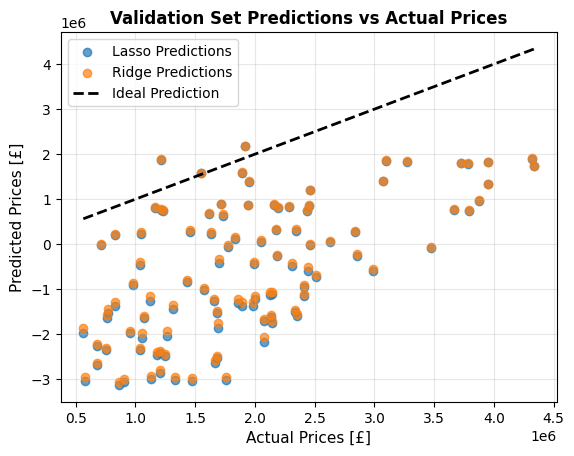

In [136]:
best_lasso_preds = best_models['Best Lasso (All)'].predict(validation_set_features_scaled)
best_ridge_preds = best_models['Best Ridge (All)'].predict(validation_set_features_scaled)

plt.scatter(validation_set_target, best_lasso_preds, label='Lasso Predictions', alpha=0.7)
plt.scatter(validation_set_target, best_ridge_preds, label='Ridge Predictions', alpha=0.7)
plt.plot([validation_set_target.min(), validation_set_target.max()],
         [validation_set_target.min(), validation_set_target.max()], 'k--', lw=2, label='Ideal Prediction')
plt.xlabel('Actual Prices [£]', fontsize=11)
plt.ylabel('Predicted Prices [£]', fontsize=11)
plt.title('Validation Set Predictions vs Actual Prices', fontsize=12, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)